In [2]:
# from scLENS import scLENS
import pandas as pd
import scanpy as sc
import torch
import numpy as np
import cupy as cp
from tqdm.auto import tqdm

In [3]:
df = pd.read_csv('./Z8eq.csv')
df

,cell,ENSG00000237683,Unknown,LINC01409,LINC00115,NOC2L,KLHL17,PLEKHN1,HES4,ISG15,...,MT-ND6,MT-CYB,ENSG00000215750,ENSG00000215781,ENSG00000220023,ENSG00000212884,ENSG00000215615,ENSG00000215764,ENSG00000215700,ENSG00000215699
0,b.cells,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,b.cells,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,b.cells,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,b.cells,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,b.cells,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3989,naive.t,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3990,naive.t,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3991,naive.t,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3992,naive.t,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# 세포 정보 추출 (cell 열)
obs = pd.DataFrame(index=df['cell']) 

# 유전자 발현 데이터 추출 (두 번째 열부터)
X = df.iloc[:, 1:].values 

# 유전자 메타데이터 생성 (열 이름 사용)
var = pd.DataFrame(index=df.columns[1:]) 

# AnnData 객체 생성
adata = sc.AnnData(X, obs=obs, var=var)

/home/l202255179/micromamba/envs/ssam_thymus/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [7]:
def preprocess(data, min_tp=0, min_genes_per_cell=200, min_cells_per_gene=15, plot=False):
    if isinstance(data, pd.DataFrame):
        if not data.index.is_unique:
            print("Cell names are not unique, resetting cell names")
            data.index = range(len(data.index))
            
        if not data.columns.is_unique:
            print("Removing duplicate genes")
            data = data.loc[:, ~data.columns.duplicated()]
        
        # DataFrame to numpy
        data_array = data.values  
    elif isinstance(data, sc.AnnData):
        data_array = data.X  # AnnData의 .X 속성을 numpy로 사용
    else:
        data_array = data
    
    # 정상 유전자 및 세포 필터링
    normal_genes = np.where((np.sum(data_array, axis=0) > min_tp) &
                            (np.count_nonzero(data_array, axis=0) >= min_cells_per_gene))[0]
    normal_cells = np.where((np.sum(data_array, axis=1) > min_tp) &
                            (np.count_nonzero(data_array, axis=1) >= min_genes_per_cell))[0]
    
    # 필터링된 데이터
    _raw = data_array[normal_cells][:, normal_genes]
    
    print(f'Removed {data_array.shape[0] - len(normal_cells)} cells and '
          f'{data_array.shape[1] - len(normal_genes)} genes in QC')
    
    # cupy 사용 (torch 대신)
    X = cp.array(_raw, dtype=cp.float64)
    
    # L1 정규화 및 로그 변환
    l1_norm = cp.linalg.norm(X, ord=1, axis=1)
    X = X / l1_norm[:, cp.newaxis]
    X += 1
    X = cp.log(X)
    
    # Z-score 정규화
    mean = cp.mean(X, axis=0)
    std = cp.std(X, axis=0)
    X = (X - mean) / std
    
    # L2 정규화
    l2_norm = cp.linalg.norm(X, ord=2, axis=1)
    X = X / l2_norm[:, cp.newaxis]
    X *= cp.mean(l2_norm)
    X -= cp.mean(X, axis=0)
    
    # cupy -> numpy 변환
    X = cp.asnumpy(X)
    
    if plot:
        # 그림 생성
        fig1, axs1 = plt.subplots(1, 2, figsize=(10, 5))
        raw = _raw
        clean = X  # 수정: numpy 상태에서 바로 사용
        
        axs1[0].hist(np.average(raw, axis=1), bins=100)
        axs1[1].hist(np.average(clean, axis=1), bins=100)
        fig1.suptitle('Mean of Gene Expression along Cells')

        fig2, axs2 = plt.subplots(1, 2, figsize=(10, 5))
        axs2[0].hist(np.std(raw, axis=0), bins=100)
        axs2[1].hist(np.std(clean, axis=0), bins=100)
        fig2.suptitle('SD of Gene Expression for each Gene')

        # anndata에 그림 저장
        if isinstance(data, sc.AnnData):
            data.uns['preprocess_mean_plot'] = fig1
            data.uns['preprocess_sd_plot'] = fig2
    
    return pd.DataFrame(X)


In [8]:
data1 = preprocess(adata)
data1

Removed 0 cells and 6065 genes in QC


,0,1,2,3,4,5,6,7,8,9,...,9641,9642,9643,9644,9645,9646,9647,9648,9649,9650
0,-0.044934,-0.062198,-0.209793,-0.043851,-0.368539,-0.069993,-0.168066,-0.220861,-0.292073,-0.102178,...,0.231515,-0.418632,-0.190431,-1.186235,0.670653,-0.124937,-0.048116,-0.088426,-0.159877,-0.157711
1,-0.042238,-0.059163,-0.199871,-0.041283,-0.351399,-0.066732,-0.160528,-0.211594,-0.278417,-0.097402,...,-0.286114,-0.398653,-0.181469,2.157507,-0.621006,-0.119329,-0.402167,-0.084440,-0.152899,-0.150666
2,-0.052136,-0.070308,-0.236299,-0.050714,-0.414334,-0.078705,-0.188206,-0.245621,-0.328557,-0.114938,...,0.029885,0.980972,-0.214374,-0.490339,1.307129,-0.139919,-0.016495,-0.099075,-0.178519,-0.176534
3,-0.023987,-0.038613,-0.132701,-0.023893,-0.235351,-0.044656,-0.109491,-0.148849,-0.185963,-0.065066,...,1.984730,3.336652,-0.120796,1.303600,0.841937,-0.081361,3.676373,-0.057453,-0.105656,-0.102967
4,-0.040228,-0.056900,-0.192474,-0.039368,-0.338618,-0.064301,-0.154907,-0.204684,-0.268235,-0.093841,...,0.637706,1.444227,-0.174788,0.488128,-0.598966,-0.115147,0.499803,-0.081468,-0.147696,-0.145413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3989,-0.044528,-0.061742,-0.208300,-0.043465,-0.365961,-0.069503,-0.166932,-0.219467,-0.290019,-0.101460,...,-0.279448,2.817029,-0.189083,0.686306,0.487506,-0.124093,-0.185954,-0.087826,-0.158827,-0.156651
3990,-0.051094,-0.069135,-0.232464,-0.049721,-0.407708,-0.077444,-0.185292,-0.242039,-0.323278,-0.113092,...,0.384867,-0.464289,-0.210909,-0.789162,-0.718114,-0.137752,0.282587,-0.097535,-0.175822,-0.173810
3991,-0.040217,-0.056888,-0.192435,-0.039358,-0.338552,-0.064288,-0.154878,-0.204647,-0.268182,-0.093822,...,0.567729,-0.383678,-0.174753,-0.248832,1.451453,-0.115126,-0.192871,-0.081453,-0.147669,-0.145385
3992,-0.036994,-0.053258,-0.180571,-0.036286,2.054767,-0.060389,-0.145863,-0.193565,-0.251852,-0.088111,...,-1.062687,-0.359785,-0.164036,-1.029085,-0.563502,-0.108419,0.270166,-0.076686,-0.139324,-0.136960


In [6]:
from scLENS import scLENS

y_true = df['cell']
df = df.drop('cell', axis=1)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
sclens = scLENS(device=device)

data2 = sclens.preprocess(df, min_genes_per_cell=200, min_cells_per_gene=15)
data2

Removed 0 cells and 6065 genes in QC


,0,1,2,3,4,5,6,7,8,9,...,9641,9642,9643,9644,9645,9646,9647,9648,9649,9650
0,-0.044928,-0.062191,-0.209766,-0.043846,-0.368493,-0.069984,-0.168045,-0.220833,-0.292036,-0.102165,...,0.231486,-0.418580,-0.190407,-1.186087,0.670569,-0.124921,-0.048110,-0.088415,-0.159856,-0.157691
1,-0.042233,-0.059156,-0.199846,-0.041278,-0.351355,-0.066724,-0.160508,-0.211567,-0.278382,-0.097390,...,-0.286078,-0.398603,-0.181447,2.157237,-0.620928,-0.119314,-0.402117,-0.084429,-0.152880,-0.150647
2,-0.052129,-0.070299,-0.236270,-0.050707,-0.414282,-0.078695,-0.188182,-0.245590,-0.328516,-0.114924,...,0.029881,0.980849,-0.214347,-0.490278,1.306966,-0.139902,-0.016493,-0.099063,-0.178497,-0.176512
3,-0.023984,-0.038608,-0.132684,-0.023890,-0.235321,-0.044651,-0.109478,-0.148830,-0.185939,-0.065058,...,1.984481,3.336234,-0.120781,1.303436,0.841831,-0.081351,3.675913,-0.057446,-0.105643,-0.102954
4,-0.040223,-0.056893,-0.192450,-0.039363,-0.338576,-0.064293,-0.154888,-0.204658,-0.268202,-0.093829,...,0.637627,1.444046,-0.174766,0.488067,-0.598891,-0.115133,0.499741,-0.081458,-0.147677,-0.145395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3989,-0.044523,-0.061734,-0.208274,-0.043460,-0.365915,-0.069494,-0.166911,-0.219440,-0.289982,-0.101447,...,-0.279413,2.816676,-0.189059,0.686220,0.487445,-0.124078,-0.185931,-0.087815,-0.158807,-0.156632
3990,-0.051087,-0.069126,-0.232435,-0.049715,-0.407657,-0.077434,-0.185269,-0.242008,-0.323238,-0.113078,...,0.384818,-0.464231,-0.210883,-0.789063,-0.718024,-0.137734,0.282552,-0.097523,-0.175800,-0.173789
3991,-0.040212,-0.056881,-0.192411,-0.039353,-0.338509,-0.064280,-0.154858,-0.204622,-0.268148,-0.093810,...,0.567658,-0.383630,-0.174731,-0.248801,1.451271,-0.115111,-0.192847,-0.081442,-0.147650,-0.145367
3992,-0.036989,-0.053252,-0.180548,-0.036282,2.054510,-0.060381,-0.145845,-0.193541,-0.251820,-0.088100,...,-1.062554,-0.359740,-0.164015,-1.028957,-0.563431,-0.108406,0.270132,-0.076676,-0.139307,-0.136943


Max interactions exceeded!
Number of signal components: 16
L_mp type: <class 'cupy.ndarray'>
L_mp shape: (3975,)


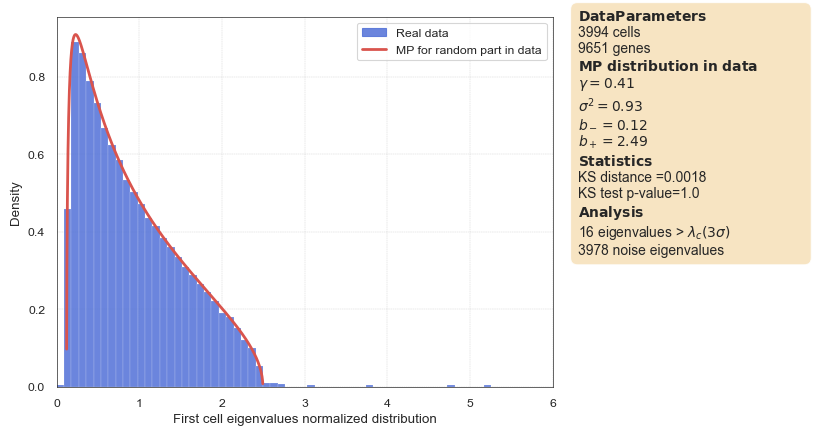

In [34]:
model1 = sclenstocupy(data1)
model1.fit(plot_mp = True)

In [56]:
import cupy as cp
import pandas as pd
from scipy import stats, linalg
import scipy

import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.lines as mlines
import matplotlib.gridspec as gridspec
from matplotlib.offsetbox import AnchoredText
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

import seaborn as sns

import psutil
import os



class sclenstocupy:
    def __init__(self, sparsity='auto', 
                 sparsity_step = 0.001, 
                 sparsity_threshold=0.9, 
                 perturbed_n_scale = 2, 
                 device = None,
                 n_rand_matrix=20,
                 threshold=0.3420201433256688,
                 data = None):
        self.L = None
        self.V = None
        self.L_mp = None
        self.explained_variance_ = []
        self.total_variance_ = []
        self.sparsity = sparsity
        self.sparsity_threshold = sparsity_threshold
        self.sparsity_step = sparsity_step
        self.preprocessed = False
        self._perturbed_n_scale = perturbed_n_scale
        self.device = device
        self.n_rand_matrix = n_rand_matrix
        self.threshold = threshold
        self.data = data


    def preprocess(self, data, min_tp=0, min_genes_per_cell=200, min_cells_per_gene=15, plot=False):
        self.data = data
        # DataFrame 처리
        if isinstance(data, pd.DataFrame):
            if not data.index.is_unique:
                print("Cell names are not unique, resetting cell names")
                data.index = range(len(data.index))

            if not data.columns.is_unique:
                print("Removing duplicate genes")
                data = data.loc[:, ~data.columns.duplicated()]

            # DataFrame을 numpy로 변환
            data_array = data.values  
        elif isinstance(data, sc.AnnData):
            data_array = data.X  # AnnData의 .X 속성은 numpy 배열로 사용
        else:
            data_array = data

        # 정상 유전자 및 세포 필터링
        self.normal_genes = np.where((np.sum(data_array, axis=0) > min_tp) &
                                (np.count_nonzero(data_array, axis=0) >= min_cells_per_gene))[0]
        self.normal_cells = np.where((np.sum(data_array, axis=1) > min_tp) &
                                (np.count_nonzero(data_array, axis=1) >= min_genes_per_cell))[0]

        # 필터링된 데이터
        self._raw = data_array[self.normal_cells][:, self.normal_genes]

        print(f'Removed {data_array.shape[0] - len(self.normal_cells)} cells and '
              f'{data_array.shape[1] - len(self.normal_genes)} genes in QC')

        # cupy 사용 (torch 대신)
        X = cp.array(self._raw, dtype=cp.float64)

        # L1 정규화 및 로그 변환
        l1_norm = cp.linalg.norm(X, ord=1, axis=1)
        X = X / l1_norm[:, cp.newaxis]
        X += 1
        X = cp.log(X)

        # Z-score 정규화
        mean = cp.mean(X, axis=0)
        std = cp.std(X, axis=0)
        X = (X - mean) / std

        # L2 정규화
        l2_norm = cp.linalg.norm(X, ord=2, axis=1)
        X = X / l2_norm[:, cp.newaxis]
        X *= cp.mean(l2_norm)
        X -= cp.mean(X, axis=0)

        # cupy -> numpy 변환
        self.X = cp.asnumpy(X)
        self.preprocessed = True

        if plot:
            # 그림 생성
            fig1, axs1 = plt.subplots(1, 2, figsize=(10, 5))
            raw = self._raw
            clean = X  # 수정: numpy 상태에서 바로 사용

            axs1[0].hist(np.average(raw, axis=1), bins=100)
            axs1[1].hist(np.average(clean.get(), axis=1), bins=100)
            fig1.suptitle('Mean of Gene Expression along Cells')

            fig2, axs2 = plt.subplots(1, 2, figsize=(10, 5))
            axs2[0].hist(np.std(raw, axis=0), bins=100)
            axs2[1].hist(np.std(clean.get(), axis=0), bins=100)
            fig2.suptitle('SD of Gene Expression for each Gene')

            # anndata에 그림 저장
            if isinstance(data, sc.AnnData):
                data.uns['preprocess_mean_plot'] = fig1
                data.uns['preprocess_sd_plot'] = fig2

        del X, l1_norm, l2_norm, mean, std

        return pd.DataFrame(self.X)
    

    def fit_transform(self, data=None, eigen_solver='wishart', plot_mp = False):

        print(self.get_cpu_memory_usage())  # CPU 메모리 사용량 출력
        print(self.get_gpu_memory_usage())  # GPU 메모리 사용량 출력
        
        if data is None and not self.preprocessed:
            raise Exception('No data has been provided. Provide data directly or through the preprocess function')
        if not self.preprocessed:
            if isinstance(data, pd.DataFrame):
                self._raw = data.values
                self.raw = data.values
            elif isinstance(data, cp.ndarray):
                self._raw = data
                self.raw = data
            else:
                raise ValueError("Data must be a pandas DataFrame or cupy ndarray")
        
        self.raw = cp.array(self.X, dtype=cp.float64)
       
        self.n_cells, self.n_genes = self.raw.shape

        if eigen_solver == 'wishart':
            self.L, self.V = self._get_eigen(self.raw)
            Xr = self._random_matrix(self.raw)
            self.Lr, self.Vr = self._get_eigen(Xr)

            self.explained_variance_ = (self.L**2) / self.n_cells
            self.total_variance_ = self.explained_variance_.sum()
            self.L_mp = self._mp_calculation(self.L, self.Lr)
            self.lambda_c = self._tw()
            self.peak = self._mp_parameters(self.L_mp)['peak']

        else:
            raise ValueError("Invalid eigen_solver. Use 'wishart'.")
        
        self.Ls = self.L[self.L > self.lambda_c]
        self.Vs = self.V[:, self.L > self.lambda_c]

        noise_boolean = ((self.L < self.lambda_c) & (self.L > self.b_minus))
        self.Vn = self.V[:, noise_boolean]
        self.Ln = self.L[noise_boolean]
        self.n_components = len(self.Ls)
        print(f"Number of signal components: {self.n_components}")

        if plot_mp:
            self.plot_mp()
        
        # pca_result : 고유값, 고유벡터
        pca_result = self.get_signal_components()
        # signal components : 고유벡터만
        self._signal_components = pca_result[1]

        if self.sparsity == 'auto':
            self._calculate_sparsity()
            
        if self.preprocessed:
            raw = cp.array(self._raw, dtype=cp.float64)

        n = min(self._signal_components.shape[1] * self._perturbed_n_scale, self.X.shape[1])
        
        pert_vecs = list()
        for _ in tqdm(range(self.n_rand_matrix), total=self.n_rand_matrix):
            # Construct random matrix
            rand = scipy.sparse.rand(self._raw.shape[0], self._raw.shape[1], 
                                    density=1-self.sparsity, 
                                    format='csr')
            rand.data[:] = 1
            rand = cp.array(rand.toarray())
        
            # Construct perturbed components
            rand += raw
            rand = self._preprocess_rand(rand)
            perturbed = self._PCA_rand(rand, n)

            # Select the most correlated components for each perturbation
            pert_select = self._signal_components.T @ perturbed
            pert_select = cp.abs(pert_select)
            pert_select = cp.argmax(pert_select, axis = 1)
            pert_vecs.append(perturbed[:, pert_select])

            del rand, perturbed, pert_select
        
        pert_scores = list()
        for i in range(self.n_rand_matrix):
            for j in range(i+1, self.n_rand_matrix):
                dots = pert_vecs[i].T @ pert_vecs[j]
                corr = cp.max(cp.abs(dots), axis = 1)
                pert_scores.append(corr.get())
        
        pert_scores = cp.array(pert_scores)
        pvals = cp.sum(pert_scores < self.threshold, axis=0) / pert_scores.shape[0]
        self._robust_idx = pvals < 0.01

        self.X_transform = pca_result[1][:, self._robust_idx] * cp.sqrt(pca_result[0][self._robust_idx]).reshape(1, -1)
        self.robust_scores = pert_scores

        del raw, pert_scores, pert_vecs
        print(self.get_cpu_memory_usage())  # CPU 메모리 사용량 출력
        print(self.get_gpu_memory_usage())  # GPU 메모리 사용량 출력

        return self.X_transform
    
        
        
    def _calculate_sparsity(self):
        """Automatic sparsity level calculation"""
        sparse = 0.999
        zero_idx = np.nonzero(self._raw == 0)
        n_len = self.X.shape[0]*self.X.shape[1]
        n_zero = zero_idx[0].shape[0]
        
        rng = np.random.default_rng()
        # Calculate threshold for correlation
        n_sampling = min(self.X.shape)
        thresh = np.mean([max(np.abs(rng.normal(0, np.sqrt(1/n_sampling), n_sampling)))
                            for _ in range(5000)]).item()
        print(f'sparsity_th: {thresh}')

        # Construct binarized data matrix
        bin = scipy.sparse.csr_array(self._raw)
        bin.data[:] = 1.
        bin = cp.array(bin.toarray(), dtype=cp.float64)
        Vb = self._PCA_rand(self._preprocess_rand(bin, inplace=False), bin.shape[0])
        n_vbp = Vb.shape[1]//2

        n_buffer = 5
        buffer = [1] * n_buffer
        while sparse > self.sparsity_threshold:
            n_pert = int((1-sparse) * n_len)
            selection = np.random.choice(n_zero,n_pert,replace=False)
            idx = [x[selection] for x in zero_idx]

            # Construct perturbed data matrix
            pert = cp.zeros_like(bin)
            pert[tuple(idx)] = 1
            pert += bin
            
            pert = self._preprocess_rand(pert)
            pert = pert @ pert.T
            pert /= pert.shape[1]
            
            Vbp = cp.linalg.eigh(pert)[1][:, -n_vbp:]
            
            del pert

            corr_arr = cp.max(cp.abs(Vb.T @ Vbp), axis=0).get()
            corr = np.sort(corr_arr)[1]
            
            buffer.pop(0)
            buffer.append(corr)
            

            print(f'Min(corr): {corr}, sparsity: {sparse}, add_ilen: {selection.shape}')
            if all([x < thresh for x in buffer]):
                 self.sparsity = sparse + self.sparsity_step * (n_buffer - 1)
                 break
            
            sparse -= self.sparsity_step
        
        del bin, Vb
            
            
    def _preprocess_rand(self, X, inplace=True):
        """Preprocessing that does not save data statistics"""
        if not inplace:
            X = X.copy()
    
        # L1 정규화 및 로그 변환
        l1_norm = cp.linalg.norm(X, ord=1, axis=1)
        X = X / l1_norm[:, cp.newaxis]
        X += 1
        X = cp.log(X)
    
        # Z-score 정규화
        mean = cp.mean(X, axis=0)
        std = cp.std(X, axis=0)
        X = (X - mean) / std
    
        # L2 정규화
        l2_norm = cp.linalg.norm(X, ord=2, axis=1)
        X = X / l2_norm[:, cp.newaxis]
        X *= cp.mean(l2_norm)
        X -= cp.mean(X, axis=0)

        del l1_norm, l2_norm, mean, std
        return X
    

    def _PCA_rand(self, X, n):
        W = (X @ X.T)
        W /= X.shape[1]
        _, V = cp.linalg.eigh(W)
        V = V[:, -n:]

        del W, _
        return V
    
    
    def get_signal_components(self, n_components=0):
        if n_components == 0:
            comp = self.Ls,  self.Vs
            return comp
        elif n_components >= 1:
            comp = self.Ls[:n_components], self.Vs[:n_components]
            return comp
        raise ValueError('n_components must be positive')
    

    def _tw(self):
        '''Tracy-Widom critical eigenvalue'''
        gamma = self._mp_parameters(self.L_mp)['gamma']
        p = len(self.L) / gamma
        sigma = 1 / cp.power(p, 2/3) * cp.power(gamma, 5/6) * \
            cp.power((1 + cp.sqrt(gamma)), 4/3)
        lambda_c = cp.mean(self.L_mp) * (1 + cp.sqrt(gamma)) ** 2 + sigma
        return lambda_c


    def _mp_calculation(self, L, Lr, eta=1, eps=10**-6, max_iter=1000):
        converged = False
        iter = 0
        loss_history = []
    
        b_plus = self._mp_parameters(Lr)['b_plus']
        b_minus = self._mp_parameters(Lr)['b_minus']
        
        L_updated = L[(L > b_minus) & (L < b_plus)]
        new_b_plus = self._mp_parameters(L_updated)['b_plus']
        new_b_minus = self._mp_parameters(L_updated)['b_minus']
    
        while not converged:
            loss = (1 - float(new_b_plus) / float(b_plus))**2
            loss_history.append(loss)
            iter += 1
        
            if loss <= eps:
                converged = True
            elif iter == max_iter:
                print('Max interactions exceeded!')
                converged = True
            else:
                gradient = new_b_plus - b_plus
                new_b_plus = b_plus + eta * gradient
                
                L_updated = L[(L > new_b_minus) & (L < new_b_plus)]
                self.b_plus = new_b_plus
                self.b_minus = new_b_minus
                
                new_b_plus = self._mp_parameters(L_updated)['b_plus']
                new_b_minus = self._mp_parameters(L_updated)['b_minus']
    
        indices = cp.where((L > new_b_minus) & (L < new_b_plus))
        L_mp = L[indices]
        return cp.array(L_mp)

    def _mp_parameters(self, L):
        moment_1 = cp.mean(L)
        moment_2 = cp.mean(cp.power(L, 2))
        gamma = moment_2 / float(moment_1**2) - 1
        s = moment_1
        sigma = moment_2
        b_plus = s * (1 + cp.sqrt(gamma))**2
        b_minus = s * (1 - cp.sqrt(gamma))**2
        x_peak = s * (1.0 - gamma)**2.0 / (1.0 + gamma)
        return {
            'moment_1': moment_1,
            'moment_2': moment_2,
            'gamma': gamma, 
            'b_plus': b_plus,
            'b_minus': b_minus,
            's': s,
            'peak': x_peak,
            'sigma': sigma
        }

    def _get_eigen(self, X):
        Y = self._wishart_matrix(X)
        L, V = cp.linalg.eigh(Y)
        return L, V

    def _wishart_matrix(self, X):
        Y = (X @ X.T)
        Y /= X.shape[1]
        return Y

    def _random_matrix(self, X):
        Xr = cp.array([
            cp.random.permutation(row) for row in X
        ])
        return Xr
    
    def style_mp_stat(self):
        plt.style.use("ggplot")
        np.seterr(invalid='ignore')
        sns.set_style("white")
        sns.set_context("paper")
        sns.set_palette("deep")
        plt.rcParams['axes.linewidth'] =0.5
        plt.rcParams['figure.dpi'] = 100

    def _marchenko_pastur(self, x, dic):
        '''Distribution of eigenvalues'''
        pdf = np.sqrt((dic['b_plus'] - x) * (x-dic['b_minus']))\
            / float(2 * dic['s'] * np.pi * dic['gamma'] * x)
        return pdf
    
    def _mp_pdf(self, x, L):
        '''Marchnko-Pastur PDF'''
        dic = self._mp_parameters(L)
        y = cp.empty_like(x)
        for i, xi in enumerate(x):
            y[i] = self._marchenko_pastur(xi, dic)
        return y
    
    def _call_mp_cdf(self,L,dic):
        "CDF of Marchenko Pastur"
        func= lambda y: list(map(lambda x: self._cdf_marchenko(x,dic), y))
        return func
    
    def _cdf_marchenko(self,x,dic):
        if x < dic['b_minus']: 
            return 0.0
        elif x>dic['b_minus'] and x<dic['b_plus']:
            return 1/float(2*dic['s']*np.pi*dic['gamma'])*\
            float(np.sqrt((dic['b_plus']-x)*(x-dic['b_minus']))+\
            (dic['b_plus']+dic['b_minus'])/2*np.arcsin((2*x-dic['b_plus']-\
            dic['b_minus'])/(dic['b_plus']-dic['b_minus']))-\
        np.sqrt(dic['b_plus']*dic['b_minus'])*np.arcsin(((dic['b_plus']+\
            dic['b_minus'])*x-2*dic['b_plus']*dic['b_minus'])/\
        ((dic['b_plus']-dic['b_minus'])*x)) )+np.arcsin(1)/np.pi
        else:
            return 1.0

    def plot_mp(self, comparison=False, path=False, info=True, bins=None, title=None):
        self.style_mp_stat()
        if bins is None:
            bins = 300

        x = np.linspace(0, int(cp.round(cp.max(self.L_mp) + 0.5)), 2000)
        y = self._mp_pdf(x, self.L_mp).get()

        if comparison and self.Lr is not None:
            yr = self._mp_pdf(x, self.Lr).get()

        # info 부분 합침
        if info:
            fig = plt.figure(dpi=100)
            fig.set_layout_engine()

            ax = fig.add_subplot(111)

            dic = self._mp_parameters(self.L_mp)
            info1 = (r'$\bf{Data Parameters}$' + '\n{0} cells\n{1} genes'
                    .format(self.n_cells, self.n_genes))
            info2 = ('\n' + r'$\bf{MP\ distribution\ in\ data}$'
                    + '\n$\gamma={:0.2f}$ \n$\sigma^2={:1.2f}$\
                    \n$b_-={:2.2f}$\n$b_+={:3.2f}$'
                    .format(dic['gamma'], dic['s'], dic['b_minus'],
                            dic['b_plus']))

            n_components = self.n_components if self.n_components is not None else 0
            info3 = ('\n' + r'$\bf{Analysis}$' +
                    '\n{0} eigenvalues > $\lambda_c (3 \sigma)$\
                    \n{1} noise eigenvalues'
                    .format(n_components, self.n_cells - n_components))

            # 디버깅
            print("L_mp type:", type(self.L_mp))
            print("L_mp shape:", self.L_mp.shape if hasattr(self.L_mp, "shape") else "No shape attribute")

            # 수정
            cdf_func = self._call_mp_cdf(self.L_mp.get(), dic)  
            ks = stats.kstest(self.L_mp.get(), cdf_func)  

            info4 = '\n'+r'$\bf{Statistics}$'+'\nKS distance ={0}'\
                .format(round(ks[0], 4))\
                + '\nKS test p-value={0}'\
                .format(round(ks[1], 2))

            infoT = info1 + info2 + info4 + info3

            ax.text(1.05, 1.02, infoT, transform=ax.transAxes, fontsize=10,
                verticalalignment='top', horizontalalignment='left',
                bbox=dict(facecolor='wheat', alpha=0.8, boxstyle='round,pad=0.5'))

            # props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)

            # at = AnchoredText(infoT, loc=2, prop=dict(size=10),
            #                 frameon=True,
            #                 bbox_to_anchor=(1., 1.024),
            #                 bbox_transform=ax.transAxes)
            # at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
            # lgd = ax.add_artist(at)
        else:
            plt.figure(dip=100)
            
        
        # distplot이 deprecated -> histplot으로 변경
        plot = sns.histplot(self.L.get(), bins=bins, stat="density",
                        kde=False, color=sns.xkcd_rgb["cornflower blue"], alpha=0.85)
    
        # MP 분포 선 (랜덤 데이터)
        plt.plot(x, y, color=sns.xkcd_rgb["pale red"], lw=2, label="MP for random part in data")


        # 범례 설정
        MP_data = mlines.Line2D([], [], color=sns.xkcd_rgb["pale red"], label="MP for random part in data", linewidth=2)
        MP_rand = mlines.Line2D([], [], color=sns.xkcd_rgb["sap green"], label="MP for randomized data", linewidth=1.5, linestyle='--')
        randomized = mpatches.Patch(color=sns.xkcd_rgb["apple green"], label="Randomized data", alpha=0.75, linewidth=3, fill=False)
        data_real = mpatches.Patch(color=sns.xkcd_rgb["cornflower blue"], label="Real data", alpha=0.85)

        # 비교가 필요한 경우
        if comparison:
            sns.histplot(self.Lr.get(), bins=30, kde=False,
                        stat="density", color=sns.xkcd_rgb["apple green"], alpha=0.75, linewidth=3)
            
            ax.plot(x, yr, sns.xkcd_rgb["sap green"], lw=1.5, ls='--')

            ax.legend(handles=[data_real, MP_data, randomized, MP_rand], loc="upper right", frameon=True)
        else:
            ax.legend(handles=[data_real, MP_data], loc="upper right", frameon=True)

        # x축 범위 설정
        max_Lr = cp.max(self.Lr) if self.Lr is not None else 0
        max_L_mp = cp.max(self.L_mp) if self.L_mp is not None else 0
        ax.set_xlim([0, int(np.round(max(max_Lr, max_L_mp) + 1.5))])

        # 격자 스타일 설정
        ax.grid(linestyle='--', lw=0.3)

        # 제목 설정
        if title:
            ax.set_title(title)
        
        # x축 레이블 설정
        ax.set_xlabel('First cell eigenvalues normalized distribution')

        if self.data is not None and isinstance(self.data, sc.AnnData):
            self.data.uns['mp_plot'] = fig

        # if path:
        #     plt.savefig(path, bbox_inches="tight")
        return fig
    
    def plot_robust_score(self):
        fig1, axs1 = plt.subplots(1, 1, figsize=(10, 5))
        for i in range(self.robust_scores.shape[1]):
            if i in np.where(self._robust_idx)[0]:
                axs1.scatter(i*np.ones_like(self.robust_scores[:, i].get()), self.robust_scores[:, i].get(), c='g', alpha=0.1)
            else:
                axs1.scatter(i*np.ones_like(self.robust_scores[:, i].get()), self.robust_scores[:, i].get(), c='r', alpha=0.1)
        axs1.axhline(y=self.threshold, color='k', linestyle='--')
        axs1.set_ylabel('Robustness Score')
        axs1.set_title('Signal Component Robustness')
    
        if isinstance(self.data, sc.AnnData):
            self.data.uns['robust_score_plot'] = fig1

    def get_cpu_memory_usage(self):
        process = psutil.Process(os.getpid())
        mem_info = process.memory_info()
        return f"CPU Memory Usage: {mem_info.rss / 1024 ** 2:.2f} MB"

    def get_gpu_memory_usage(self):
        device = cp.cuda.Device(0)
        # 메모리 풀 확인
        mempool = cp.get_default_memory_pool()
        pinned_mempool = cp.get_default_pinned_memory_pool()

        # 현재 사용 중인 메모리 (bytes)
        used_bytes = mempool.used_bytes() / 1024 ** 2
        total_bytes = mempool.total_bytes() / 1024 ** 2

        return used_bytes, total_bytes
        

    

In [57]:
device_id = cp.cuda.Device(0) if cp.cuda.is_available() else None
cupy = sclenstocupy(device = device_id)

In [58]:
cupy.preprocess(adata)

Removed 0 cells and 6065 genes in QC


,0,1,2,3,4,5,6,7,8,9,...,9641,9642,9643,9644,9645,9646,9647,9648,9649,9650
0,-0.044934,-0.062198,-0.209793,-0.043851,-0.368539,-0.069993,-0.168066,-0.220861,-0.292073,-0.102178,...,0.231515,-0.418632,-0.190431,-1.186235,0.670653,-0.124937,-0.048116,-0.088426,-0.159877,-0.157711
1,-0.042238,-0.059163,-0.199871,-0.041283,-0.351399,-0.066732,-0.160528,-0.211594,-0.278417,-0.097402,...,-0.286114,-0.398653,-0.181469,2.157507,-0.621006,-0.119329,-0.402167,-0.084440,-0.152899,-0.150666
2,-0.052136,-0.070308,-0.236299,-0.050714,-0.414334,-0.078705,-0.188206,-0.245621,-0.328557,-0.114938,...,0.029885,0.980972,-0.214374,-0.490339,1.307129,-0.139919,-0.016495,-0.099075,-0.178519,-0.176534
3,-0.023987,-0.038613,-0.132701,-0.023893,-0.235351,-0.044656,-0.109491,-0.148849,-0.185963,-0.065066,...,1.984730,3.336652,-0.120796,1.303600,0.841937,-0.081361,3.676373,-0.057453,-0.105656,-0.102967
4,-0.040228,-0.056900,-0.192474,-0.039368,-0.338618,-0.064301,-0.154907,-0.204684,-0.268235,-0.093841,...,0.637706,1.444227,-0.174788,0.488128,-0.598966,-0.115147,0.499803,-0.081468,-0.147696,-0.145413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3989,-0.044528,-0.061742,-0.208300,-0.043465,-0.365961,-0.069503,-0.166932,-0.219467,-0.290019,-0.101460,...,-0.279448,2.817029,-0.189083,0.686306,0.487506,-0.124093,-0.185954,-0.087826,-0.158827,-0.156651
3990,-0.051094,-0.069135,-0.232464,-0.049721,-0.407708,-0.077444,-0.185292,-0.242039,-0.323278,-0.113092,...,0.384867,-0.464289,-0.210909,-0.789162,-0.718114,-0.137752,0.282587,-0.097535,-0.175822,-0.173810
3991,-0.040217,-0.056888,-0.192435,-0.039358,-0.338552,-0.064288,-0.154878,-0.204647,-0.268182,-0.093822,...,0.567729,-0.383678,-0.174753,-0.248832,1.451453,-0.115126,-0.192871,-0.081453,-0.147669,-0.145385
3992,-0.036994,-0.053258,-0.180571,-0.036286,2.054767,-0.060389,-0.145863,-0.193565,-0.251852,-0.088111,...,-1.062687,-0.359785,-0.164036,-1.029085,-0.563502,-0.108419,0.270166,-0.076686,-0.139324,-0.136960


In [59]:
%%time
cupy.fit_transform()

CPU Memory Usage: 4431.77 MB
(1.45751953125, 3628.66162109375)
Max interactions exceeded!
Number of signal components: 16
sparsity_th: 0.05999409707909026
Min(corr): 0.08956320071781379, sparsity: 0.999, add_ilen: (38546,)
Min(corr): 0.07588170229130281, sparsity: 0.998, add_ilen: (77092,)
Min(corr): 0.07068616831570833, sparsity: 0.997, add_ilen: (115638,)
Min(corr): 0.06492396358412546, sparsity: 0.996, add_ilen: (154184,)
Min(corr): 0.06245571561350238, sparsity: 0.995, add_ilen: (192730,)
Min(corr): 0.060377026732927636, sparsity: 0.994, add_ilen: (231276,)
Min(corr): 0.05939865853112641, sparsity: 0.993, add_ilen: (269822,)
Min(corr): 0.05817665158766149, sparsity: 0.992, add_ilen: (308368,)
Min(corr): 0.05724501464508536, sparsity: 0.991, add_ilen: (346914,)
Min(corr): 0.05580030116188148, sparsity: 0.99, add_ilen: (385460,)
Min(corr): 0.056275598792559126, sparsity: 0.989, add_ilen: (424007,)


  0%|          | 0/20 [00:00<?, ?it/s]

CPU Memory Usage: 4431.77 MB
(955.1396484375, 3628.66162109375)
CPU times: user 1min 29s, sys: 6.2 s, total: 1min 36s
Wall time: 1min 35s


array([[ 0.04105718, -0.03826169, -0.02644869, ..., -0.14582109,
         0.06994112, -0.02711196],
       [ 0.02534541, -0.00069116, -0.02015234, ..., -0.13098915,
         0.07156501, -0.03700359],
       [ 0.00774764,  0.00759813, -0.02913346, ..., -0.13624159,
         0.05192215, -0.0357052 ],
       ...,
       [-0.00412252,  0.00800009,  0.00269003, ...,  0.02358551,
        -0.06861508,  0.0384025 ],
       [ 0.02841542, -0.01079739,  0.00910996, ...,  0.02328334,
        -0.00856293, -0.05428069],
       [ 0.01457923,  0.03640545,  0.01290544, ...,  0.03067032,
        -0.01833608, -0.08521219]])

CPU Memory Usage: 4431.84 MB
(661.04931640625, 3628.66162109375)
Max interactions exceeded!
Number of signal components: 16
L_mp type: <class 'cupy.ndarray'>
L_mp shape: (3975,)


  0%|          | 0/20 [00:00<?, ?it/s]

CPU Memory Usage: 4431.85 MB
(955.47509765625, 3628.66162109375)


array([[-0.05611275,  0.04105718, -0.03826169, ..., -0.14582109,
         0.06994112, -0.02711196],
       [ 0.0008668 ,  0.02534541, -0.00069116, ..., -0.13098915,
         0.07156501, -0.03700359],
       [-0.00687943,  0.00774764,  0.00759813, ..., -0.13624159,
         0.05192215, -0.0357052 ],
       ...,
       [-0.05226174, -0.00412252,  0.00800009, ...,  0.02358551,
        -0.06861508,  0.0384025 ],
       [-0.00174218,  0.02841542, -0.01079739, ...,  0.02328334,
        -0.00856293, -0.05428069],
       [ 0.02898098,  0.01457923,  0.03640545, ...,  0.03067032,
        -0.01833608, -0.08521219]])

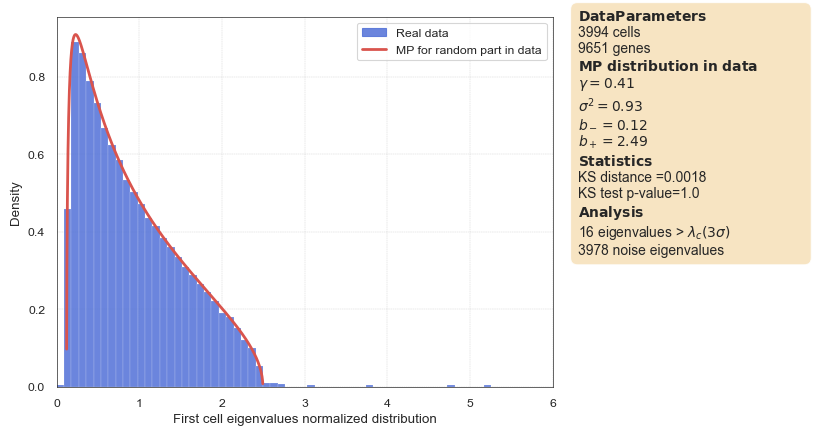

In [62]:
cupy.fit_transform(plot_mp = True)

In [65]:
cupy.X_transform

array([[-0.05611275,  0.04105718, -0.03826169, ..., -0.14582109,
         0.06994112, -0.02711196],
       [ 0.0008668 ,  0.02534541, -0.00069116, ..., -0.13098915,
         0.07156501, -0.03700359],
       [-0.00687943,  0.00774764,  0.00759813, ..., -0.13624159,
         0.05192215, -0.0357052 ],
       ...,
       [-0.05226174, -0.00412252,  0.00800009, ...,  0.02358551,
        -0.06861508,  0.0384025 ],
       [-0.00174218,  0.02841542, -0.01079739, ...,  0.02328334,
        -0.00856293, -0.05428069],
       [ 0.02898098,  0.01457923,  0.03640545, ...,  0.03067032,
        -0.01833608, -0.08521219]])

In [63]:
adata.uns

OrderedDict([('robust_score_plot', <Figure size 1000x500 with 1 Axes>),
             ('mp_plot', <Figure size 640x480 with 1 Axes>)])

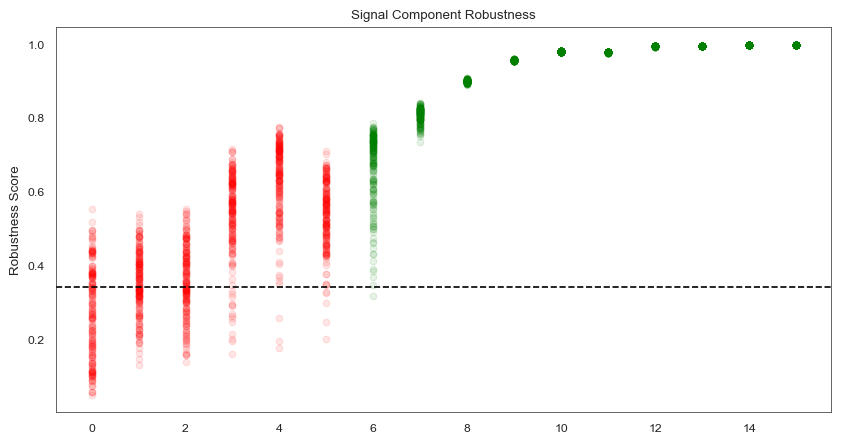

In [64]:
adata.uns['robust_score_plot']

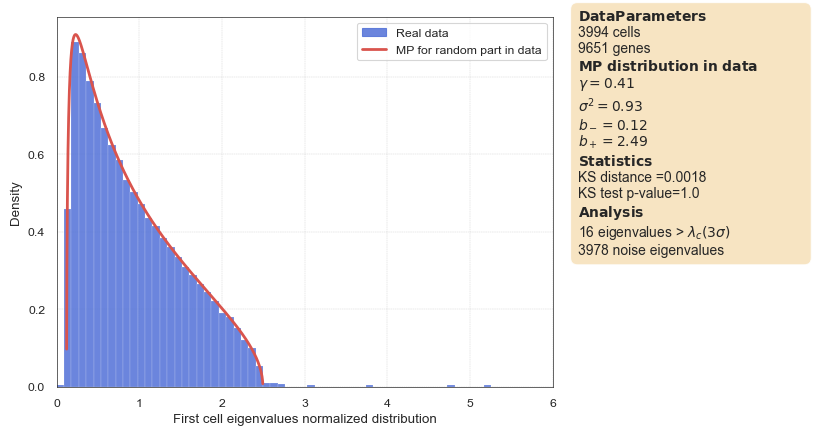

In [55]:
adata.uns['mp_plot']

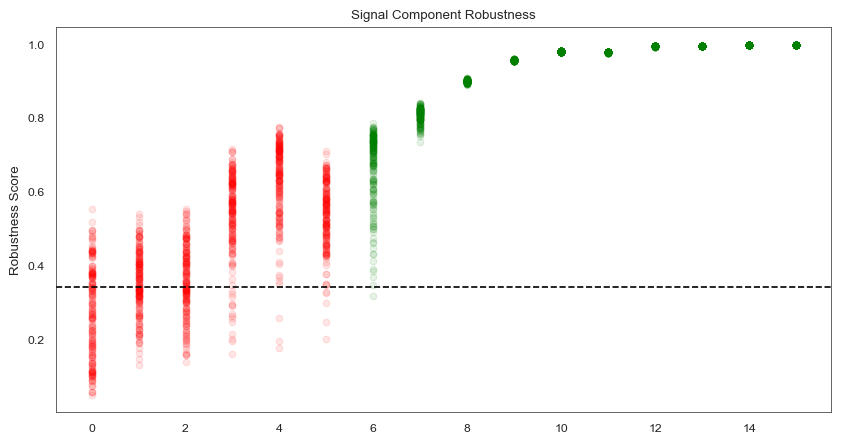

In [61]:
adata.uns['robust_score_plot']

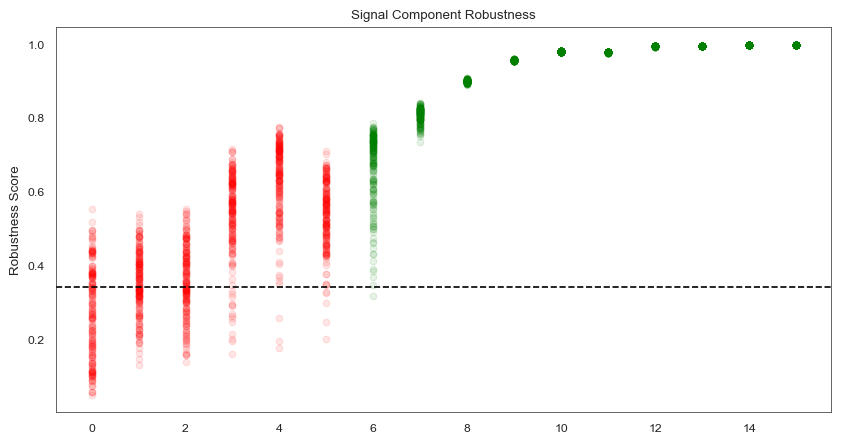

In [60]:
cupy.plot_robust_score()

In [43]:
adata.uns

OrderedDict([('robust_score_plot', <Figure size 1000x500 with 2 Axes>)])

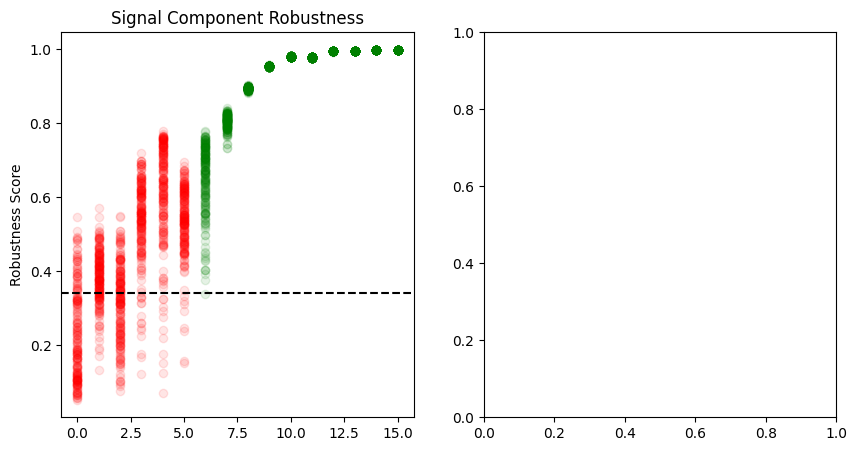

In [44]:
adata.uns['robust_score_plot']

In [63]:
sclens._signal_components

array([[-8.77429746e-03,  1.07269978e-02, -3.64611201e-03, ...,
        -3.98247574e-02,  1.54356789e-02, -5.24358181e-03],
       [-1.04908596e-04,  6.19893283e-03, -2.82968579e-02, ...,
        -3.57740531e-02,  1.57940639e-02, -7.15666980e-03],
       [ 7.42759525e-05, -2.08849795e-02, -2.29317263e-03, ...,
        -3.72085311e-02,  1.14589774e-02, -6.90555501e-03],
       ...,
       [ 2.07196541e-02, -3.73965878e-02, -7.23144324e-04, ...,
         6.44136649e-03, -1.51430285e-02,  7.42722663e-03],
       [ 1.23228978e-03,  6.25761879e-04,  2.28548730e-02, ...,
         6.35884391e-03, -1.88979874e-03, -1.04981439e-02],
       [-2.31131101e-02,  2.94222247e-02, -1.67599586e-02, ...,
         8.37627920e-03, -4.04668718e-03, -1.64804427e-02]])

In [65]:
cupy.X_transform

array([[-0.03826169, -0.02644869,  0.04044216, ..., -0.14582109,
         0.06994112, -0.02711196],
       [-0.00069116, -0.02015234,  0.02560884, ..., -0.13098915,
         0.07156501, -0.03700359],
       [ 0.00759813, -0.02913346, -0.01168169, ..., -0.13624159,
         0.05192215, -0.0357052 ],
       ...,
       [ 0.00800009,  0.00269003,  0.00197925, ...,  0.02358551,
        -0.06861508,  0.0384025 ],
       [-0.01079739,  0.00910996, -0.0051903 , ...,  0.02328334,
        -0.00856293, -0.05428069],
       [ 0.03640545,  0.01290544, -0.02773451, ...,  0.03067032,
        -0.01833608, -0.08521219]])

In [14]:
cupy.X_transform.shape

(3994, 10)

In [11]:
cupy._robust_idx

array([False, False, False, False, False, False, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

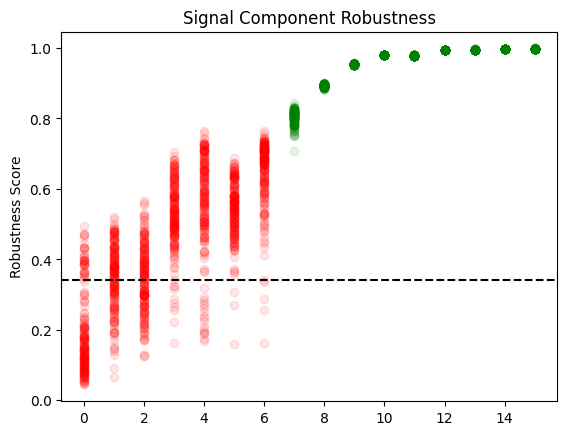

In [9]:
cupy.plot_robust_score()

In [12]:
cupy.robust_scores

array([[0.05104287, 0.4017768 , 0.29770068, ..., 0.99541487, 0.99763092,
        0.99826785],
       [0.05671894, 0.46541858, 0.51076023, ..., 0.99536507, 0.99758239,
        0.99836672],
       [0.20697242, 0.48044976, 0.29647319, ..., 0.99527424, 0.99764787,
        0.99837096],
       ...,
       [0.10968832, 0.22348469, 0.22348469, ..., 0.99550036, 0.9977495 ,
        0.99841494],
       [0.08740932, 0.39347427, 0.39347427, ..., 0.99535951, 0.99771453,
        0.99835057],
       [0.4453792 , 0.22609003, 0.4453792 , ..., 0.9953082 , 0.99759837,
        0.99844248]])

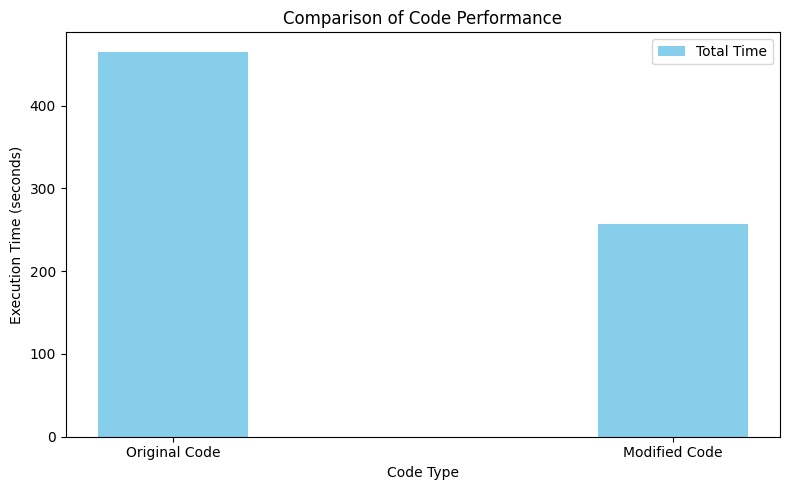

In [34]:
import matplotlib.pyplot as plt
import numpy as np

total_times = [67.129+292+106, 59.998 + 99 + 98]


# x축 레이블
labels = ['Original Code', 'Modified Code']

# 바의 폭
bar_width = 0.3
x = np.arange(len(labels))

# 그래프 그리기
fig, ax = plt.subplots(figsize=(8, 5))

# CPU time bar
ax.bar(x, total_times, bar_width, label='Total Time', color='skyblue')

# 레이블 및 제목 설정
ax.set_xlabel('Code Type')
ax.set_ylabel('Execution Time (seconds)')
ax.set_title('Comparison of Code Performance')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# 그래프 출력
plt.tight_layout()
plt.show()


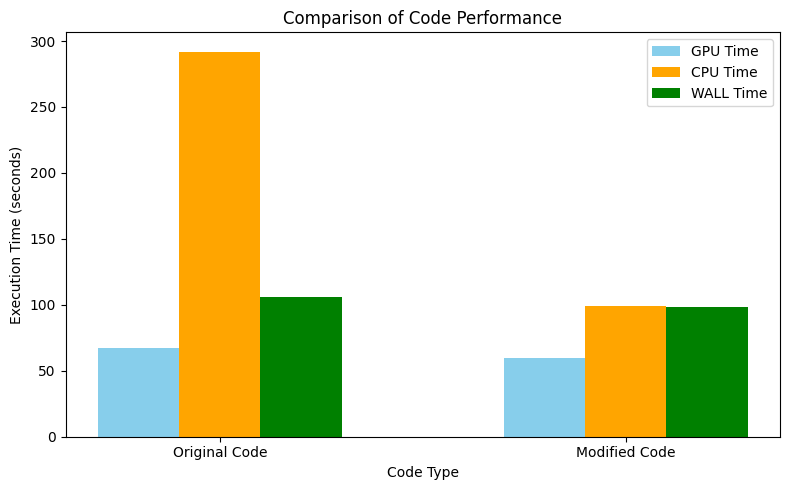

In [31]:
import matplotlib.pyplot as plt
import numpy as np

gpu_times = [67.129+292, 59.998+99]
cpu_times = [292,99]
wall_times = [106, 98]

# x축 레이블
labels = ['Original Code', 'Modified Code']

# 바의 폭
bar_width = 0.2
x = np.arange(len(labels))

# 그래프 그리기
fig, ax = plt.subplots(figsize=(8, 5))

# CPU time bar
ax.bar(x-bar_width, gpu_times, bar_width, label='GPU Time', color='skyblue',)
ax.bar(x, cpu_times, bar_width, label='CPU Time', color='orange')
ax.bar(x+bar_width, wall_times, bar_width, label='WALL Time', color='green')


# 레이블 및 제목 설정
ax.set_xlabel('Code Type')
ax.set_ylabel('Execution Time (seconds)')
ax.set_title('Comparison of Code Performance')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# 그래프 출력
plt.tight_layout()
plt.show()


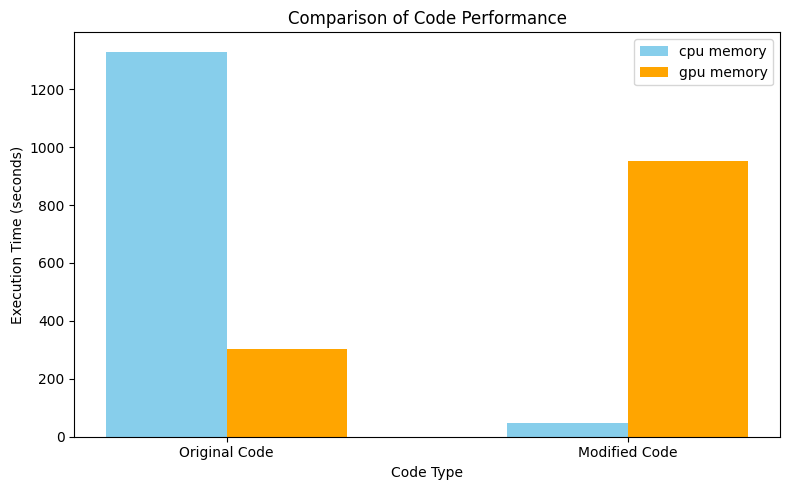

In [35]:
import matplotlib.pyplot as plt
import numpy as np

cpu_memory = [1330, 46.41]
gpu_memory = [302.70, 953.65]
total_memory = [1330+302.70, 46.41+953.65]

# x축 레이블
labels = ['Original Code', 'Modified Code']

# 바의 폭
bar_width = 0.3
x = np.arange(len(labels))

# 그래프 그리기
fig, ax = plt.subplots(figsize=(8, 5))

# CPU time bar
ax.bar(x-bar_width/2, cpu_memory, bar_width, label='cpu memory', color='skyblue')
ax.bar(x+bar_width/2, gpu_memory, bar_width, label = 'gpu memory', color = 'orange')
# 레이블 및 제목 설정
ax.set_xlabel('Code Type')
ax.set_ylabel('Execution Time (seconds)')
ax.set_title('Comparison of Code Performance')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# 그래프 출력
plt.tight_layout()
plt.show()


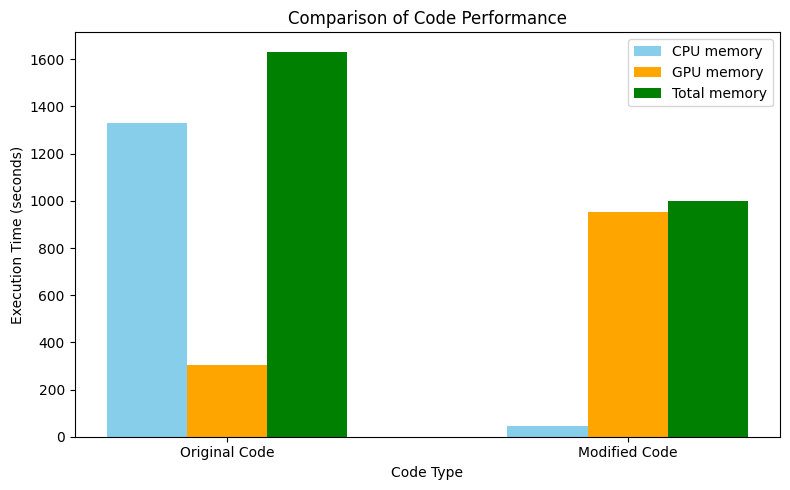

In [37]:
import matplotlib.pyplot as plt
import numpy as np

cpu_memory = [1330, 46.41]
gpu_memory = [302.70, 953.65]
total_memory = [1330+302.70, 46.41+953.65]

# x축 레이블
labels = ['Original Code', 'Modified Code']

# 바의 폭
bar_width = 0.2
x = np.arange(len(labels))

# 그래프 그리기
fig, ax = plt.subplots(figsize=(8, 5))

# CPU time bar
ax.bar(x-bar_width, cpu_memory, bar_width, label='CPU memory', color='skyblue',)
ax.bar(x, gpu_memory, bar_width, label='GPU memory', color='orange')
ax.bar(x+bar_width, total_memory, bar_width, label='Total memory', color='green')


# 레이블 및 제목 설정
ax.set_xlabel('Code Type')
ax.set_ylabel('Execution Time (seconds)')
ax.set_title('Comparison of Code Performance')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# 그래프 출력
plt.tight_layout()
plt.show()
